# Other

In [21]:
# human (sox9) chr17:72121019-72126416
# SOX9	SOX9	BestRefSeq	protein_coding	chr17	72121019	72126416	+	SRY-box transcription factor 9	

import pysam

fasta = pysam.FastaFile("/home/chenzonggui/labweb/data/genomes/homo_sapiens/genome.fasta")
seq = fasta.fetch("chr17", 72121019, 72126416)
fasta.close()

In [23]:
with open("human.sox9.fasta", "w+") as fw:
    fw.write(">human-sox9\n")
    fw.write("%s\n" % seq)

In [28]:
with open("map_human_sox9.chain") as f, open("map_human_sox9.bed", "w+") as fw:
    lines = None
    for line in f:
        line = line.strip("\n")
        if line.startswith("#"):
            continue
        if line.startswith("chain"):
            lines = [line]
        elif line == "":
            assert len(lines) > 1
            chain, score, tname, tsize, tstrand, tstart, tend, qname, qsize, qstrand, qstart, qend, i = lines[0].split(" ")
            print(len(lines))
            tstart = int(tstart)
            tend = int(tend)
            
            chrom = tname
            start = tstart
            end = tend
            name = "homoloy"
            strand = qstrand
            score = int(score)
            color = "0,0,255"
            block_sizes = []
            block_offsets = []
            offset = 0
            for l in lines[1:]:
                vs = l.split("\t")
                a = int(vs[0])
                block_sizes.append(a)
                block_offsets.append(offset)
                
                offset += a
                if len(vs) > 1:
                    b = int(vs[1])
                    offset += b
                # print(len(vs))
            s1 = ",".join(map(str, block_sizes)) + ","
            s2 = ",".join(map(str, block_offsets)) + ","
            s3 = "\t".join(map(str, [chrom, start, end, name, score, strand, start, start, color, len(block_sizes), s1, s2]))
            # print(s3)
            fw.write(s3 + "\n")
            
                
        else:
            lines.append(line)
        

33
22
34
32
30
36
5
4
4
3
3
6
3
4
5
5
3
3
2
5
4
2
2
2
3
6
6
2
7
2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn
rcParams["font.family"] = "arial"

In [98]:
dat = pd.read_csv("genome.sizes", sep="\t", header=None)
dat = dat.sort_values(by=1, ascending=False)

xs = [78093715, 37502051]
colors = ["orange", 'orange']
yticks = ["chr4 (Zebrafish)", "chr25 (Zebrafish)"]

for name, length in dat.head(10).values:
    # print(name, length)
    xs.append(length)
    yticks.append(name)
    colors.append("dodgerblue")
    
ys = np.arange(len(xs))[::-1]

xs = np.array(xs) / 1e6

plt.figure(figsize=(4, 3))
plt.barh(ys, xs, height=0.8, lw=1, edgecolor="black", color=colors)
plt.xlim(0, 100)
plt.xlabel("Length of refSeq (Mb)")
plt.ylim(-0.5, 11.5)
plt.yticks(ys, yticks)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("refSeq.length.png", dpi=300)
plt.close()

In [8]:
from collections import Counter

In [4]:
dat = pd.read_csv("GCF_002260705.1_Sdu_1.0_genomic.tsv", sep="\t")
tids1 = set(dat[dat["BioType"] == "protein_coding"]["TranscriptID"].values)
tids2 = set(dat[dat["BioType"] == "lncRNA"]["TranscriptID"].values)

In [12]:
from pyBioInfo.IO.File import BedFile

In [40]:
path1 = "cpat.protein_coding.cds.bed"
path2 = "cpat.lncRNA.bed"

fw1 = open(path1, "w+")
fw2 = open(path2, "w+")
recorder1 = set()
recorder2 = set()
a, b, c, d = 0, 0, 0, 0
with BedFile("GCF_002260705.1_Sdu_1.0_genomic.sorted.bed") as bed:
    for obj in bed:
        key = (obj.chrom, obj.start, obj.end, obj.strand)
        if obj.name in tids1:
            a += 1
            if obj.thick:
                if key in recorder1:
                    continue
                b += 1
                x = obj.clip(obj.thick[0], obj.thick[1])
                fw1.write(x.format("BED") + "\n")
                recorder1.add(key)
        if obj.name in tids2:
            c += 1
            if key in recorder2:
                continue
            d += 1
            fw2.write(obj.format("BED") + "\n")
            recorder2.add(key)
fw1.close()
fw2.close()
print(a, b, c, d)

33024 26818 745 710


# Lastz


In [24]:
import time
import os
import multiprocessing
import pysam
import gzip
import matplotlib.pyplot as plt

In [3]:
fasta = pysam.FastaFile("GCF_002260705.1_Sdu_1.0_genomic.fasta")

In [60]:
references = sorted([(r, fasta.get_reference_length(r)) for r in fasta.references], key=lambda x: x[1], reverse=True)

In [63]:
batches = []
batch = []
batch_l = 0
for reference, length in references:
    if batch_l >= 20000000:
        batches.append(batch)
        batch = []
        batch_l = 0
    batch.append((reference, length))
    batch_l += length
if len(batch) > 0:
    batches.append(batch)

In [84]:
taskes = []
for i in range(len(batches)):
    for j in range(i, len(batches)):
        b1 = batches[i]
        b2 = batches[j]   
        path = "selfaligned/%s_vs_%s.axt.gz" % (i, j)
        taskes.append([b1, b2, path])
        # print(path)

In [91]:
def execute(task):
    b1, b2, path = task
    path1 = path + ".ref.fasta"
    path2 = path + ".que.fasta"
    with pysam.FastaFile("GCF_002260705.1_Sdu_1.0_genomic.fasta") as fasta:
        with open(path1, "w+") as fw:
            for ref, length in b1:
                seq = fasta.fetch(ref)
                fw.write(">%s\n" % ref)
                fw.write("%s\n" % seq)
        with open(path2, "w+") as fw:
            for ref, length in b2:
                seq = fasta.fetch(ref)
                fw.write(">%s\n" % ref)
                fw.write("%s\n" % seq)
    cmd = "lastz %s[multiple] %s --format=axt | gzip -c > %s" % (path1, path2, path)
    assert os.system(cmd) == 0
    os.remove(path1)
    os.remove(path2)
        
pool = multiprocessing.Pool(processes = 80)
for task in taskes:
    pool.apply_async(execute, (task, )) 
pool.close()
pool.join()


In [11]:
ref_lengths = dict()
with open("GCF_002260705.1_Sdu_1.0_genomic.sizes") as f:
    for line in f:
        k, v  = line.strip("\n").split("\t")
        v = int(v)
        ref_lengths[k] = v
ref_offsets = dict()
offset = 0
for ref, length in ref_lengths.items():
    ref_offsets[ref] = offset
    offset += length

In [58]:
array = []
for fname in os.listdir("selfaligned"):
    if fname.endswith(".axt.gz"):
        path = "selfaligned/%s" % fname
        # print(path)
        with gzip.open(path, "rt") as f:
            n = 0
            for line in f:
                if line.startswith("#"):
                    continue
                line = line.strip("\n")
                m = n % 4
                if m == 0:
                    vs = line.split()
                    num, rname, rstart, rend, qname, qstart, qend, strand, score = vs
                    rstart = int(rstart) - 1
                    rend = int(rend)
                    if strand == "+":
                        qstart = int(qstart) - 1
                        qend = int(qend)
                    else:
                        qstart, qend = ref_lengths[qname] - int(qend), ref_lengths[qname] - int(qstart) + 1
                        # print(qend)
                    xs = (rstart + ref_offsets[rname], rend + ref_offsets[rname])
                    #w = rend - rstart
                    if strand == "+":
                        ys = (qstart + ref_offsets[qname], qend + ref_offsets[qname])
                    else:
                        ys = (qend + ref_offsets[qname], qstart + ref_offsets[qname])
                    #h = int(qend - qstart)
                    #if h / w > 10:
                        #print(line)
                        #print(rstart, rend, qstart, qend, ref_lengths[qname])
                    array.append([xs, ys])
                    # break
                n += 1
        # break

In [59]:
len(array)

4259776

In [60]:
array[0]

[(19310, 19454), (126206001, 126206150)]

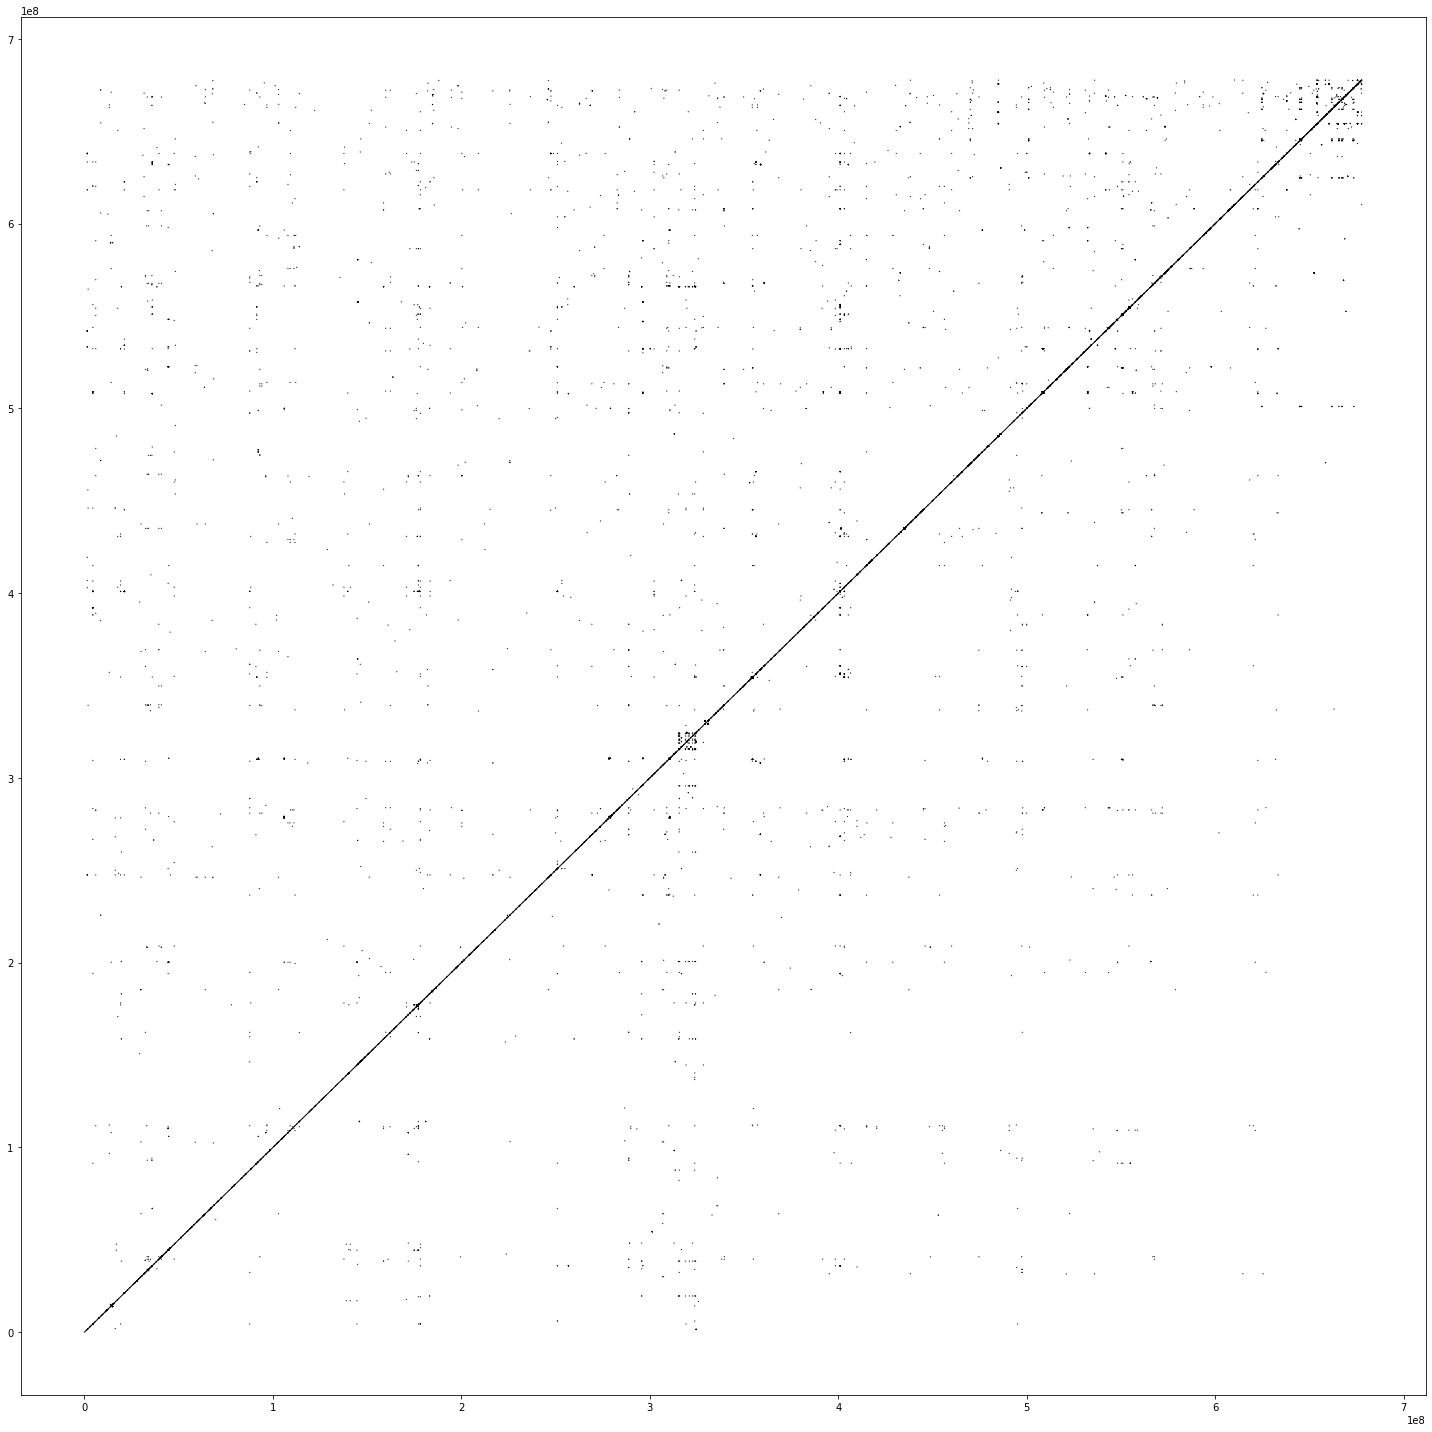

In [66]:
plt.figure(figsize=(20, 20))
for xs, ys in array:
    w = abs(xs[1] - xs[0])
    h = abs(ys[1] - ys[0])
    if w / h < 0.1:
        print(w, h)
    if w <= 5000:
        continue
    if h <= 5000:
        continue
    plt.plot(xs, ys, ls="-", lw=1, color="black")
plt.tight_layout()
plt.show()
plt.close()

# 2021-03-23 Gene gap

In [230]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from pyBioInfo.IO.File import GtfFile, GffFile
rcParams["font.family"] = "arial"

In [216]:
# gaotishi
with GtfFile("GCF_002260705.1_Sdu_1.0_genomic.sorted.gtf.gz") as f:
    records = [x for x in f]
    
genes = []
for record in records:
    if record.feature == "gene":
        biotype = record.attributes["gene_biotype"]
        if biotype == "protein_coding" or biotype == "lncRNA":
            genes.append(record)
            
container = defaultdict(list)
for gene in genes:
    container[gene.chrom].append(gene)
    
lengths = []
for chrom in container.keys():
    blocks = [[record.start, record.end] for record in sorted(container[chrom])]
    blocks = BlockTools.suture(blocks)
    for i in range(len(blocks) - 1):
        lengths.append(blocks[i + 1][0] - blocks[i][1])
        
lengths1 = lengths

In [217]:
# huangshan
with GtfFile("/home/chenzonggui/species/monopterus_albus/GCF_001952655.1_M_albus_1.0_genomic.sorted.gtf.gz") as f:
    records = [x for x in f]
    
genes = []
for record in records:
    if record.feature == "gene":
        biotype = record.attributes["gene_biotype"]
        if biotype == "protein_coding" or biotype == "lncRNA":
            genes.append(record)
            
container = defaultdict(list)
for gene in genes:
    container[gene.chrom].append(gene)
    
lengths = []
for chrom in container.keys():
    blocks = [[record.start, record.end] for record in sorted(container[chrom])]
    blocks = BlockTools.suture(blocks)
    for i in range(len(blocks) - 1):
        lengths.append(blocks[i + 1][0] - blocks[i][1])
        
lengths2 = lengths

In [223]:
# banmayu
with GffFile("/home/chenzonggui/data/banmayu_yushanshan/data/danio_rerio/annotation.gff.gz") as f:
    records = [x for x in f]
    
genes = []
for record in records:
    if record.feature == "gene":
        biotype = record.attributes["gene_biotype"]
        if biotype == "protein_coding" or biotype == "lncRNA":
            genes.append(record)
            
container = defaultdict(list)
for gene in genes:
    container[gene.chrom].append(gene)
    
lengths = []
for chrom in container.keys():
    blocks = [[record.start, record.end] for record in sorted(container[chrom])]
    blocks = BlockTools.suture(blocks)
    for i in range(len(blocks) - 1):
        lengths.append(blocks[i + 1][0] - blocks[i][1])
        
lengths3 = lengths

In [224]:
# renlei
with GtfFile("/home/chenzonggui/species/homo_sapiens/gencode.v37.annotation.sorted.gtf.gz") as f:
    records = [x for x in f]
    
genes = []
for record in records:
    if record.feature == "gene":
        biotype = record.attributes["gene_type"]
        if biotype == "protein_coding" or biotype == "lncRNA":
            genes.append(record)
            
container = defaultdict(list)
for gene in genes:
    container[gene.chrom].append(gene)
    
lengths = []
for chrom in container.keys():
    blocks = [[record.start, record.end] for record in sorted(container[chrom])]
    blocks = BlockTools.suture(blocks)
    for i in range(len(blocks) - 1):
        lengths.append(blocks[i + 1][0] - blocks[i][1])
        
lengths4 = lengths

In [228]:
array = [lengths1, lengths2, lengths3, lengths4]
array = [np.log10(np.array(lengths) + 1) for lengths in array]

In [254]:
list(map(len, array))

[21282, 19588, 31590, 21883]

In [252]:
xs = [1, 2, 3, 4]
xticks = ["greater\namberjack", "finless\neel", "zebrafish","human"]
plt.figure(figsize=(3, 3))
plt.boxplot(array, positions=xs, showfliers=False)
plt.xticks(xs, xticks, rotation=45)
plt.ylim(0, 8)
plt.ylabel("Length of intergenic region\nlog$_{10}$(L + 1)")
plt.tight_layout()
plt.grid(axis="y", ls="--", lw=1, color="lightgrey")
if False:
    plt.show()
else:
    plt.savefig("gene.gap.length.png", dpi=300)
plt.close()